In [2]:
import cv2 as cv
from os import listdir
import preprocess_lego_image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Note that Keras now has a lot more functionality than when I initially wrote some of the below code. Loading data is now much easier with [`image_dataset_from_directory`](https://keras.io/api/data_loading/image/). There are also many [code examples](https://keras.io/examples/) involving image classification that will probably work better than the below code. However, this will give a good introduction and a surprisingly accurate model (at least for my data). 

In [3]:
data_dir_labeled = '/data/labeled'
labels = listdir(data_dir_labeled)
labels.sort()
labels

['15712tile1x1withopenoclip', '3023plate1x2', '43857liftarmthick1x2']

In [4]:
def load_data():
    data = []
    for label in labels:
        label_path = f'{data_dir_labeled}/{label}'
        image_paths = listdir(label_path)
        for image_path in image_paths:                
            image = preprocess_lego_image.preprocess(f'{label_path}/{image_path}')
            data.append([label, image])
    return data

labeled_data = load_data()

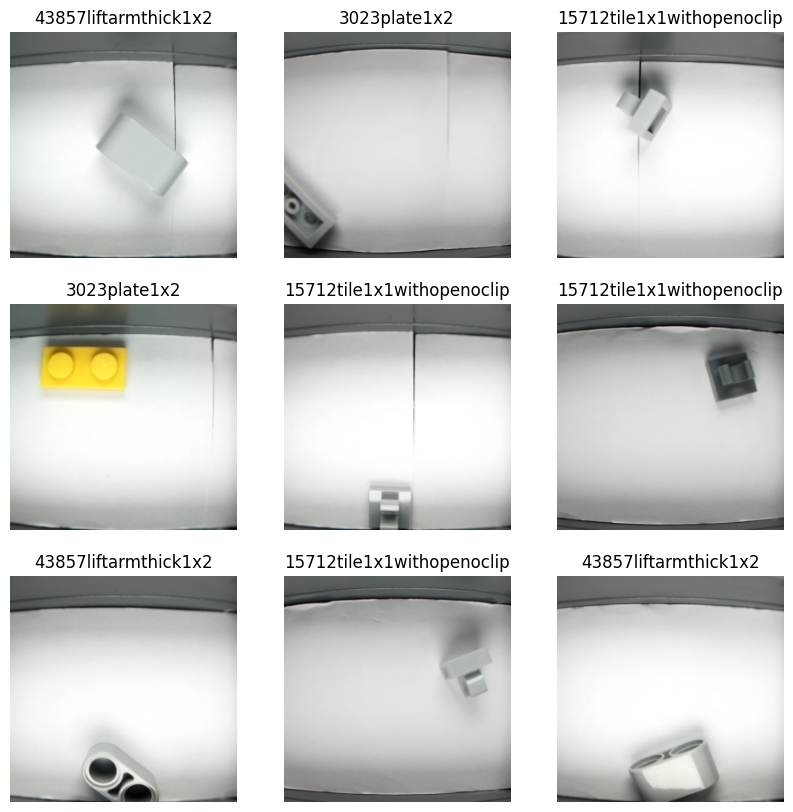

In [5]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis("off")
    i = i + 1

In [6]:
df = pd.DataFrame(labeled_data,columns = ['label','image'])
data_train = df.sample(frac=0.8, random_state=1)
data_test = df.drop(data_train.index)
print(f'# training data: {len(data_train)}')
print(f'# training data: {len(data_test)}')

# training data: 465
# training data: 116


In [7]:
from tensorflow.keras.utils import to_categorical
X_train = np.array(data_train.drop(['label'], axis=1))
y_train = to_categorical(np.array(data_train['label'].apply(lambda l: labels.index(l))))
X_test = np.array(data_test.drop(['label'], axis=1))
y_test = to_categorical(np.array(data_test['label'].apply(lambda l: labels.index(l))))

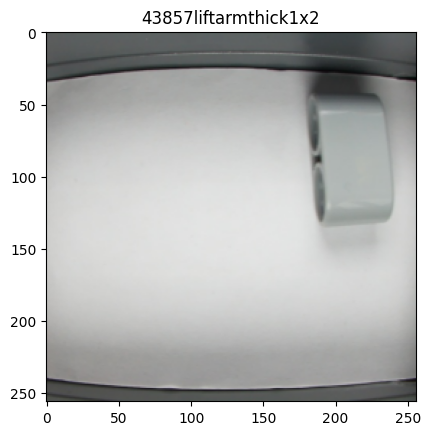

In [8]:
#sanity check
random_index = random.randint(0, len(X_train) - 1)
plt.title(labels[np.argmax(y_train[random_index])])
plt.imshow(cv.cvtColor(X_train[random_index][0], cv.COLOR_BGR2RGB))

In [9]:
L = []
for k in X_train:
    L += [k[0]]
L = np.array(L)
X_train = L
X_train.shape

(465, 256, 256, 3)

In [10]:
P = []
for k in X_test:
    P += [k[0]]
P = np.array(P)
X_test = P
X_test.shape

(116, 256, 256, 3)

In [11]:
X_test[0].shape

(256, 256, 3)

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)
X_test.shape

(116, 256, 256, 3)

In [26]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
for layer in vgg16.layers:
    layer.trainable = False
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
x = tf.keras.layers.Flatten()(vgg16.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

In [28]:
model = tf.keras.models.Model(vgg16.input, output)

In [29]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [30]:
model.build([None, 256, 256, 3])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,558,467 (120.39 MB)

 Trainable params: 16,843,779 (64.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [31]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=200, verbose=1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3458 - loss: 0.3821 - val_accuracy: 0.4741 - val_loss: 0.3163
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step - accuracy: 0.4863 - loss: 0.3285 - val_accuracy: 0.3276 - val_loss: 0.4465
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step - accuracy: 0.3613 - loss: 0.4199 - val_accuracy: 0.5172 - val_loss: 0.2966
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - accuracy: 0.5633 - loss: 0.2742 - val_accuracy: 0.5517 - val_loss: 0.2797
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step - accuracy: 0.5708 - loss: 0.2672 - val_accuracy: 0.4483 - val_loss: 0.3554
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step - accuracy: 0.5082 - loss: 0.2944 - val_accuracy: 0.4052 - val_loss: 0.3745
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - accuracy: 0.5889 - loss: 0.2593 - val_accuracy: 0.5776 - val_loss: 0.2419
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - accuracy: 0.6810 - loss: 0.1831 - val_accuracy: 0.6724 - val_loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


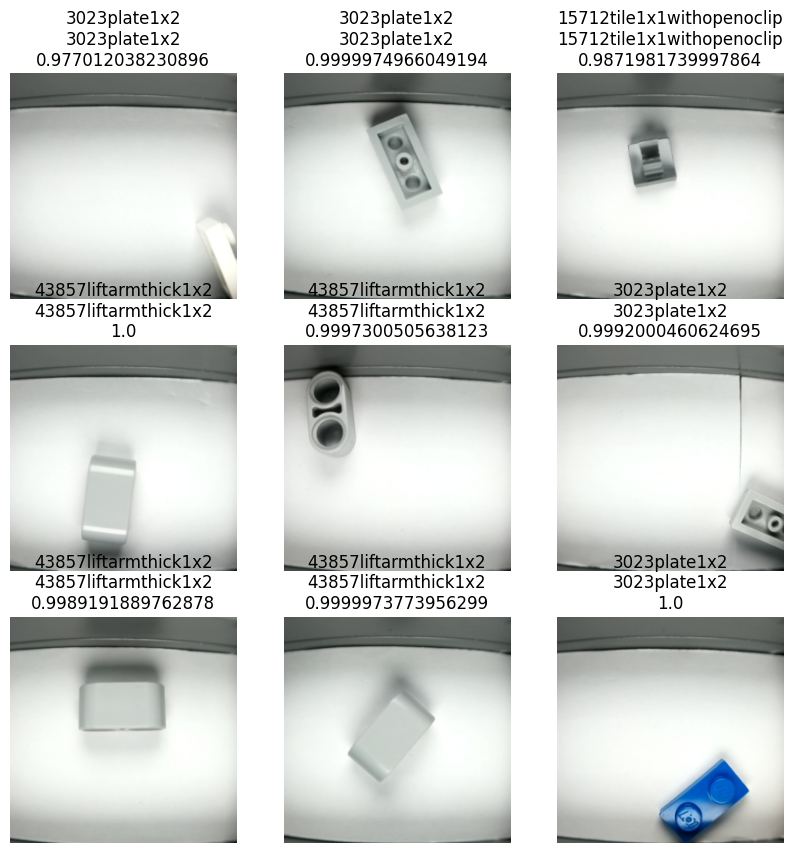

In [32]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    expected_label, example_image = random.sample(labeled_data, 1)[0]
    prediction = model.predict(preprocess_input(np.array([example_image])))
    most_likely = np.argmax(prediction)
    predicted_label = labels[most_likely]
    predicted_prob = prediction[0][most_likely]
    plt.title(f'{expected_label}\n{predicted_label}\n{predicted_prob}')
    plt.imshow(cv.cvtColor(example_image, cv.COLOR_BGR2RGB))
    plt.axis("off")
    i = i + 1

In [34]:
# fine tuning
for layer in vgg16.layers:
    layer.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [35]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 1.0000 - loss: 1.6122e-05 - val_accuracy: 0.9397 - val_loss: 0.0330
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 1.0000 - loss: 4.0110e-06 - val_accuracy: 0.9483 - val_loss: 0.0317
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step - accuracy: 1.0000 - loss: 1.6859e-06 - val_accuracy: 0.9483 - val_loss: 0.0326
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 529ms/step - accuracy: 1.0000 - loss: 5.9876e-07 - val_accuracy: 0.9310 - val_loss: 0.0341
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - accuracy: 1.0000 - loss: 4.4230e-07 - val_accuracy: 0.9224 - val_loss: 0.0354
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 1.0000 - loss: 4.2832e-07 - val_accuracy: 0.9224 - val_loss: 0.0358
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step - accuracy: 1.0000 - loss: 3.5009e-07 - val_accuracy: 0.9224 - val_loss: 0.0355
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 1.0000 - loss: 2.4453e-07 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


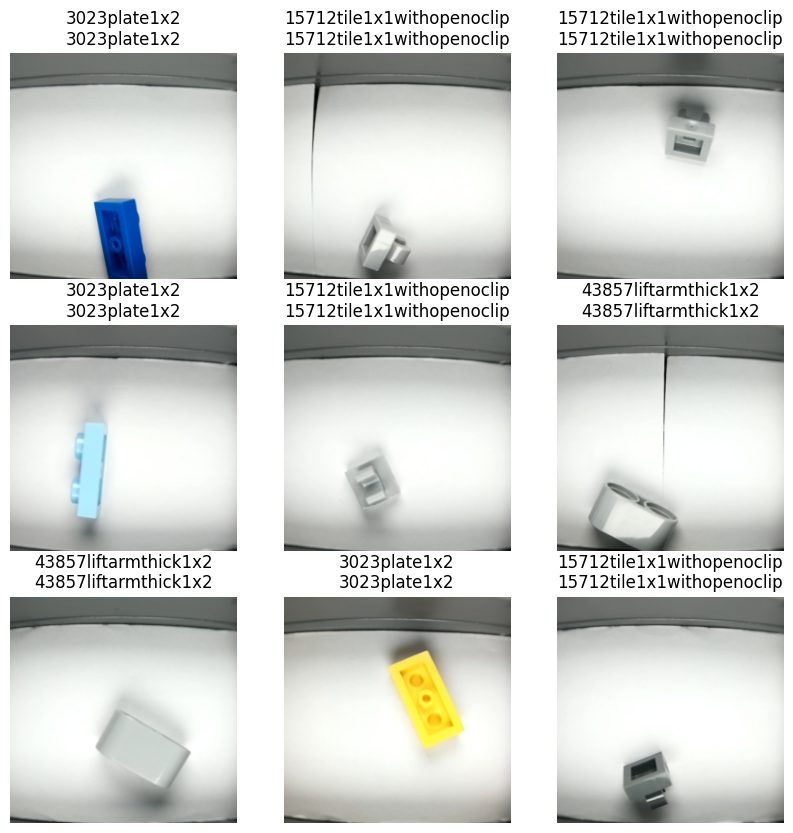

In [36]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    expected_label, example_image = random.sample(labeled_data, 1)[0]
    prediction = model.predict(preprocess_input(np.array([example_image])))
    np.argmax(prediction)
    predicted_label = labels[np.argmax(prediction)]
    plt.title(f'{expected_label}\n{predicted_label}')
    plt.imshow(cv.cvtColor(example_image, cv.COLOR_BGR2RGB))
    plt.axis("off")
    i = i + 1

In [37]:
model.save('model.keras')

We now have a trained model that is stored in `model.keras`. In the next notebook, we will use this model to classify images and convert it into a REST API that can be used by the Raspberry Pi controlling the LEGO sorter.